### Dependencies and Global Constants

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('max_columns',500)
pd.set_option('max_rows',500)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42

from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

from sklearn.metrics import (confusion_matrix, auc, roc_curve, cohen_kappa_score, accuracy_score)
import seaborn as sns

### Data Preparation

In [16]:
kddCupTrain = pd.read_csv('kddCupTrain.csv',header=None)
kdd_test = pd.read_csv('kddCupTest.csv',header=None)
#Rename Class Column
kddCupTrain.rename(columns={41:'Class'},inplace=True)
#Convert values to 0 and 1
kddCupTrain['Class'] = np.where(kddCupTrain['Class']=='normal.',0,1)

#Save and Drop Class column for combined processing
trafficClass  = kddCupTrain['Class']
kddCupTrain.drop(['Class'],axis=1,inplace=True)

#Combined Processing of Train and Test data to get equal one-hot columns
combo = pd.concat([kddCupTrain,kdd_test])
#Remove unwanted columns
combo.drop([7,19],axis=1,inplace=True)
#One hot encoding
combo_ohe = pd.get_dummies(combo)
#split the data 
kddCupTrain_ohe = combo_ohe.iloc[:kddCupTrain.shape[0],:]
kdd_test_ohe = combo_ohe.iloc[kddCupTrain.shape[0]:,:]


#Standardize columns which have max values more than 1
idx = (kddCupTrain_ohe.apply(max) >1).values
#Train standardization
scaler = StandardScaler()
kddCupTrain_ohe.iloc[:,idx] = scaler.fit_transform(kddCupTrain_ohe.iloc[:,idx].values)
#Test standardization
idx = (kdd_test_ohe.apply(max) >1).values
kdd_test_ohe.iloc[:,idx] = scaler.transform(kdd_test_ohe.iloc[:,idx].values)

#Add clas column back
kddCupTrain_ohe['Class'] = trafficClass


c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [17]:
kddCupTrain_ohe.shape, kdd_test_ohe.shape

((985262, 109), (196557, 108))

### Create Train Test Split

In [18]:
X_train_split, X_test_split = train_test_split(kddCupTrain_ohe,test_size=0.2,
                                  stratify=kddCupTrain_ohe['Class'],
                                  random_state=RANDOM_SEED)

y_train = X_train_split['Class']
X_train = X_train_split.drop(['Class'],axis=1)

y_test = X_test_split['Class']
X_test = X_test_split.drop(['Class'],axis=1)

print('Train: shape X', X_train.shape,', shape Y',y_train.shape)
print('Test: shape X', X_test.shape,', shape Y',y_test.shape)

Train: shape X (788209, 108) , shape Y (788209,)
Test: shape X (197053, 108) , shape Y (197053,)


### Create data for Autoencoder with only Normal examples

In [19]:
X_trainNorm = X_train[y_train==0]
X_trainNorm_val = X_trainNorm.values
X_testNorm_val = X_test[y_test==0].values

### Create Autoencoder network

In [20]:
input_dim = X_trainNorm_val.shape[1]
print('Input Dim: ',input_dim)
layer1_dim = 14
encoder_dim = 7

Input Dim:  108


In [21]:
input_layer = Input(shape=(input_dim,))
encoder1 = Dense(layer1_dim,activation='tanh')(input_layer)
encoder2 = Dense(encoder_dim,activation='relu')(encoder1)

decoder1 = Dense(layer1_dim,activation='tanh')(encoder2)
decoder2 = Dense(input_dim,activation='linear')(decoder1)

autoencoder = Model(inputs=input_layer,outputs=decoder2)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 108)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 14)                1526      
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_7 (Dense)              (None, 14)                112       
_________________________________________________________________
dense_8 (Dense)              (None, 108)               1620      
Total params: 3,363
Trainable params: 3,363
Non-trainable params: 0
_________________________________________________________________


### Train the Model and save to disk

In [22]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam',loss='mse')
checkpointer = ModelCheckpoint(filepath='Model.h5', verbose=0,save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss',patience=1,verbose=0)
history = autoencoder.fit(X_trainNorm_val,X_trainNorm_val,
                         epochs=nb_epoch,
                         batch_size=batch_size,
                         shuffle = True,
                         validation_data = (X_testNorm_val,X_testNorm_val),
                         verbose=1,
                         callbacks=[checkpointer,earlystopping]).history

Train on 778224 samples, validate on 194557 samples
Epoch 1/100
778224/778224 [==============================] - 20s 26us/step - loss: 0.0911 - val_loss: 0.0840
Epoch 2/100
778224/778224 [==============================] - 21s 27us/step - loss: 0.0786 - val_loss: 0.0771
Epoch 3/100
778224/778224 [==============================] - 21s 26us/step - loss: 0.0712 - val_loss: 0.0724
Epoch 4/100
778224/778224 [==============================] - 20s 26us/step - loss: 0.0661 - val_loss: 0.0678
Epoch 5/100
778224/778224 [==============================] - 20s 25us/step - loss: 0.0621 - val_loss: 0.0661
Epoch 6/100
778224/778224 [==============================] - 19s 25us/step - loss: 0.0596 - val_loss: 0.0641
Epoch 7/100
778224/778224 [==============================] - 19s 25us/step - loss: 0.0576 - val_loss: 0.0632
Epoch 8/100
778224/778224 [==============================] - 19s 25us/step - loss: 0.0566 - val_loss: 0.0631
Epoch 9/100
778224/778224 [==============================] - 19s 24us/step -

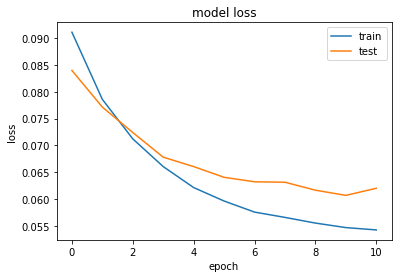

In [23]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Evaluation

In [24]:
#Load the trained model
autoencoder = load_model('Model.h5')
#Predictions for test data
testPredictions = autoencoder.predict(X_test)
X_test.shape,testPredictions.shape

#Mean Squared Error for reconstruction error
testMSE = mean_squared_error(X_test.transpose(),testPredictions.transpose(),
                            multioutput='raw_values')
error_df = pd.DataFrame({'reconstruction_error':testMSE,'true_class':y_test})
error_df.head()

#Reconstruction error for normal traffic
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]

#Reconstruction error for Attack traffic
fraud_error_df = error_df[error_df['true_class'] == 1]

#ROC stats
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
print('AUC: ',roc_auc)

#Threshold for reconstruction error above which which the traffic will be
#classified as Attack
threshold = normal_error_df.reconstruction_error.quantile(q=0.975)
print('Threshold :',threshold)

#Prepare y_pred based on the threshold
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]

#Confustion matrix
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
print('Confustion Matrix: ',conf_matrix)

#Cohen kappa and Accuracy
ck = cohen_kappa_score(error_df.true_class, y_pred),accuracy_score(error_df.true_class, y_pred)
print('Cohen Kappa , Accuracy: ',ck)

AUC:  0.9891700382314957
Threshold : 0.03043796886668186
Confustion Matrix:  [[189650   4907]
 [    12   2484]]
Cohen Kappa , Accuracy:  (0.492874138504272, 0.9750371727403288)


### Predict on Test Data

In [25]:
testPredictions = autoencoder.predict(kdd_test_ohe)
testPredictions.shape

(196557, 108)

In [26]:
#Mean Squared Error for reconstruction error
testMSE = mean_squared_error(kdd_test_ohe.transpose(),testPredictions.transpose(),
                            multioutput='raw_values')
error_df = pd.DataFrame({'reconstruction_error':testMSE})
error_df.head()

,reconstruction_error
0,0.000538
1,0.002569
2,0.003537
3,0.000583
4,0.002698


In [27]:
error_df.to_csv('result2.csv')